In [36]:
from src.helpers import *
from src.fix_ssl import FixSSL
from src.sentiment_preprocessing import TextPreprocessing
from src.sentiment_scoring import SentimentScoring
from src.sentiment_postprocessing import PostProcessing
import pandas as pd

## Supress warnings if needed
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# Get data

In [37]:
DO_SCORING_FLAG = True
DO_PREPROCESSING_FLAG = True
DO_POSTPROCESSING_FLAG = True

VALIDATION_SIZE = 500
VERSION = f"_val{VALIDATION_SIZE}_hf"

parsed = pd.read_csv('data/validation_data_hf_en.csv')
parsed['language'] = 'en'

parsed.rename(columns={'text':'Sentence', 'label_name':'Sentiment'}, inplace=True)

print(parsed.shape)
parsed.head()

(5057, 5)


,Unnamed: 0,Sentence,labels,Sentiment,language
0,0,COPYRIGHT AFX News and AFX Financial News Logo...,1,neutral,en
1,1,Satama and Trainers ' House will remain as nam...,1,neutral,en
2,2,Prices and delivery volumes of broadband produ...,0,negative,en
3,3,"When open next year , it will be the largest f...",2,positive,en
4,4,The tower 's engineers have created an 18 degr...,1,neutral,en


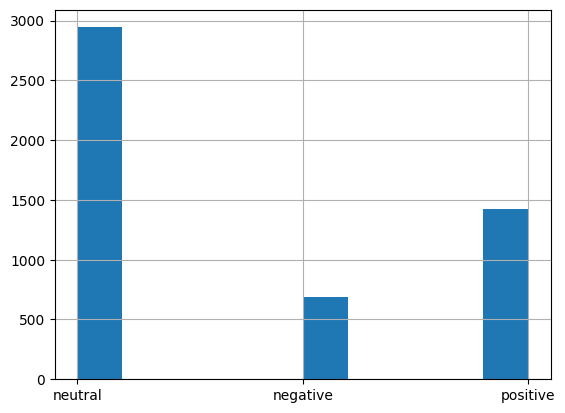

In [38]:
parsed['Sentiment'].hist();

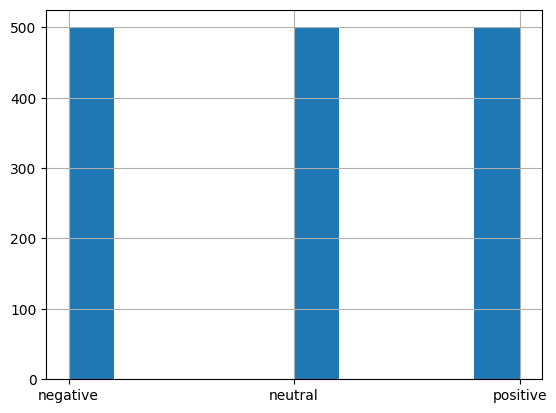

In [39]:
stratified = parsed.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(VALIDATION_SIZE, random_state=1))
stratified['Sentiment'].hist();

In [40]:
data = stratified.copy()

## Text preprocessing

In [41]:
text_cols = ['Sentence']

In [42]:
filename = f"data/preprocessed{VERSION}.pkl"

if DO_PREPROCESSING_FLAG:
    tp = TextPreprocessing(text_cols, 'language', verbose=True, keep_original_cols=True)
    preprocessed = tp.transform(data)
    to_pickle(file=preprocessed, filename=filename)
else:
    preprocessed = from_pickle(filename)

# Ad hoc
m = preprocessed['language'] == 'en'
preprocessed[m].head(1)

Step 1 - lowercasing
Lower-cased, shapes before:(1500, 6) / after:(1500, 6)
example: incap furniture is presently negotiating staff cuts .
Step 2 - tokenisation
Tokenized, shapes before:(1500, 6) / after:(1500, 6)
example: ['incap', 'furniture', 'is', 'presently', 'negotiating', 'staff', 'cuts', '.']
Step 3 - remove punctuation
Remove punctuation, shapes before:(1500, 6) / after:(1500, 6)
example: ['incap', 'furniture', 'is', 'presently', 'negotiating', 'staff', 'cuts']
Step 4 - remove stopwords
Remove stopwords, shapes before:(1500, 6) / after:(1500, 6)
example: ['incap', 'furniture', 'presently', 'negotiating', 'staff', 'cuts']
Step 5 - joining tokens into single string
Step 6 - lematisation
Lemmatisation, shapes before:(1500, 6) / after:(1500, 6)
example: incap furniture presently negotiate staff cut


,Unnamed: 0,Sentence,labels,Sentiment,language,Sentence_original
0,1248,incap furniture presently negotiate staff cut,0,negative,en,Incap Furniture is presently negotiating staff...


## Sentiment

#### check SSL connection

In [43]:
# cert_filepath = "src/ssl/hf_root.crt"
# url = 'https://huggingface.co'
# port = 443

# fs = FixSSL(host=url, port=port, verbose=True)
# fs.run(cert_filepath)

#### scoring

In [44]:
filename = f"data/scored{VERSION}.pkl"

if DO_SCORING_FLAG:
    # Rule based models
    sa = SentimentScoring(text_cols, 'language')
    scored = sa.transform(preprocessed)
    #save result
    to_pickle(file=scored, filename=filename)
else:
    scored = from_pickle(filename)


SCORING  ==============================
 column: Sentence
  Textblob model - RUNNING
  Textblob model - DONE!
  Transfomer models:
   nlptown/bert-base-multilingual-uncased-sentiment - Running
   nlptown/bert-base-multilingual-uncased-sentiment - DONE!
   oliverguhr/german-sentiment-bert - Running
   oliverguhr/german-sentiment-bert - DONE!
   citizenlab/twitter-xlm-roberta-base-sentiment-finetunned - Running
   citizenlab/twitter-xlm-roberta-base-sentiment-finetunned - DONE!
   marianna13/bert-multilingual-sentiment - Running
   marianna13/bert-multilingual-sentiment - DONE!
   z-dickson/multilingual_sentiment_newspaper_headlines - Running


Some layers from the model checkpoint at z-dickson/multilingual_sentiment_newspaper_headlines were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at z-dickson/multilingual_sentiment_newspaper_headlines.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


   z-dickson/multilingual_sentiment_newspaper_headlines - DONE!


In [45]:
print(scored.shape)

#Ad hoc
m = scored['language'] == 'en'
scored[m].head()

(1500, 12)


,Unnamed: 0,Sentence,labels,Sentiment,language,Sentence_original,Sentence_tb_sentiment,Sentence_nlptown_sentiment,Sentence_oliverguhr_sentiment,Sentence_citizenlab_sentiment,Sentence_marianna13_sentiment,Sentence_z-dickson_sentiment
0,1248,incap furniture presently negotiate staff cut,0,negative,en,Incap Furniture is presently negotiating staff...,0.00,1 star,negative,Neutral,5 stars,neutral
1,135,operate profit 12 month period decrease eur5 ....,0,negative,en,Operating profit for the 12-month period decre...,0.00,1 star,neutral,Neutral,5 stars,negative
2,2414,operate profit non recur item eur 8.3 mn first...,0,negative,en,Operating profit before non-recurring items wa...,0.25,1 star,neutral,Neutral,5 stars,negative
3,287,q1 2009 bank land 's net interest income weake...,0,negative,en,"In Q1 of 2009 , Bank of +_land 's net interest...",0.00,1 star,negative,Neutral,1 star,negative
4,3562,adp news feb 12 2009 finnish construction comp...,0,negative,en,"( ADP News ) - Feb 12 , 2009 - Finnish constru...",0.00,1 star,negative,Neutral,1 star,negative


# postprocessing

In [46]:
filename_norm = f"data/normalized{VERSION}.pkl"
filename_resc_str = f"data/rescaled_str{VERSION}.pkl"
filename_resc_int = f"data/rescaled_int{VERSION}.pkl"

if DO_POSTPROCESSING_FLAG:
    pp = PostProcessing()

    normalized, rescaled_str, rescaled_int = pp.transform(scored)

    #save result
    to_pickle(file=normalized, filename=filename_norm)
    to_pickle(file=rescaled_str, filename=filename_resc_str)
    to_pickle(file=rescaled_int, filename=filename_resc_int)
else:
    normalized = from_pickle(filename=filename_norm)
    rescaled_str = from_pickle(filename=filename_resc_str)
    rescaled_int = from_pickle(filename=filename_resc_int)

POSTPROCESSING:
 normalaizing scores...
  done!
 rescaling scores (string)...
  done!
 rescaling scores (integer)...
  done!


In [47]:
print(normalized.shape)
display(normalized.head(1))

print(rescaled_str.shape)
display(rescaled_str.head(1))

print(rescaled_int.shape)
display(rescaled_int.head(1))

(1500, 12)


,Unnamed: 0,Sentence,labels,Sentiment,language,Sentence_original,Sentence_tb_sentiment,Sentence_nlptown_sentiment,Sentence_oliverguhr_sentiment,Sentence_citizenlab_sentiment,Sentence_marianna13_sentiment,Sentence_z-dickson_sentiment
0,1248,incap furniture presently negotiate staff cut,0,negative,en,Incap Furniture is presently negotiating staff...,0,1,-1,0,5,0


(1500, 12)


,Unnamed: 0,Sentence,labels,Sentiment,language,Sentence_original,Sentence_tb_sentiment,Sentence_nlptown_sentiment,Sentence_oliverguhr_sentiment,Sentence_citizenlab_sentiment,Sentence_marianna13_sentiment,Sentence_z-dickson_sentiment
0,1248,incap furniture presently negotiate staff cut,0,negative,en,Incap Furniture is presently negotiating staff...,neutral,negative,negative,neutral,positive,neutral


(1500, 12)


,Unnamed: 0,Sentence,labels,Sentiment,language,Sentence_original,Sentence_tb_sentiment,Sentence_nlptown_sentiment,Sentence_oliverguhr_sentiment,Sentence_citizenlab_sentiment,Sentence_marianna13_sentiment,Sentence_z-dickson_sentiment
0,1248,incap furniture presently negotiate staff cut,0,negative,en,Incap Furniture is presently negotiating staff...,0,-1,-1,0,1,0


# Validation

In [177]:
from sklearn.metrics import classification_report
import plotly.express as px
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib as plt

In [133]:
validation_data = rescaled_str.drop(columns=['Sentence_z-dickson_sentiment'])
print(validation_data.shape)

(1500, 11)


In [134]:
def get_metrics(input_data):
    y_true = input_data['Sentiment']
    model_preds = [col for col in input_data.columns if "sentiment" in col]

    metrics = pd.DataFrame()
    for model_pred in model_preds:   
        y_pred = input_data[model_pred]
        tmp = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, zero_division=0))
        tmp['model'] = model_pred
        metrics = pd.concat((metrics, tmp), axis=0)
    metrics = metrics.reset_index().rename(columns={'index':'metric'})
    metrics['model'] = metrics['model'].str.replace('Sentence_','').str.replace('_sentiment','')
    return metrics

def get_sample(data, size, n):
    for i in range(n):
        yield i, data.sample(size, replace=True, random_state=i)

In [147]:
metrics_bootstraped = pd.DataFrame()
metrics = get_metrics(validation_data)

for i, sample in get_sample(validation_data, 100, 1000):
    metrics_temp = get_metrics(sample)
    metrics_temp['sample'] = i
    metrics_bootstraped = pd.concat((metrics_bootstraped, metrics_temp), axis=0)
metrics_main = metrics[['model','metric','accuracy','macro avg']]

In [136]:
def print_box(data, var, w=500, h=400, save_to_folder='reports'):
    data = data.sort_values(by=var, ascending=False)
    fig = px.box(data, x='model', y=var, width=w, height=h, labels={"accuracy": "accuracy"})
    fig.update_layout(bargap=0.1, paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
    if save_to_folder:
        fig.write_image(f"{save_to_folder}/val_{var}_bootstraped.png")
    fig.show()

In [186]:
print_box(metrics_bootstraped.drop_duplicates(subset=['accuracy', 'model']), var='accuracy', w=600, h=400,)

In [187]:
print_box(metrics_bootstraped[metrics_bootstraped['metric']=='precision'].rename(columns={'macro avg':'precision'}), var='precision', w=600, h=400,)

In [188]:
print_box(metrics_bootstraped[metrics_bootstraped['metric']=='recall'].rename(columns={'macro avg':'recall'}), var='recall', w=600, h=400,)

In [189]:
print_box(metrics_bootstraped[metrics_bootstraped['metric']=='f1-score'].rename(columns={'macro avg':'f1-score'}), var='f1-score', w=600, h=400,)

### Graphs

In [141]:
def print_bar(data, var, w=500, h=400, save_to_folder='reports'):
    data = data.sort_values(by=var, ascending=False)
    fig = px.bar(data, x='model', y=var, width=w, height=h, labels={"accuracy": "accuracy"})
    fig.update_layout(bargap=0.1, paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
    if save_to_folder:
        fig.write_image(f"{save_to_folder}/val_{var}.png")
    fig.show()

In [142]:
print_bar(data = metrics_main.drop_duplicates(subset=['accuracy', 'model']), var = 'accuracy', w=700, h=400)

In [143]:
print_bar(data = metrics[metrics['metric']=='precision'].rename(columns={'macro avg':'precision'}), var = 'precision', w=700, h=400)

In [144]:
print_bar(data = metrics[metrics['metric']=='recall'].rename(columns={'macro avg':'recall'}), var = 'recall', w=700, h=400)

In [145]:
print_bar(data = metrics[metrics['metric']=='f1-score'].rename(columns={'macro avg':'F1-score'}), var = 'F1-score', w=700, h=400)

## Confusion matricies

In [175]:
def get_confusion_matricies(input_data, save_to_folder='reports'):
    y_true = input_data['Sentiment']
    model_preds = [col for col in input_data.columns if "sentiment" in col]

    matricies = dict()
    for model_pred in model_preds:   
        y_pred = input_data[model_pred]
        fig = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues, colorbar=False)
        matricies[model_pred] = fig
        if save_to_folder:
            fig.figure_.savefig(f"reports/val_cm_{model_pred.replace('Sentence_','').replace('_sentiment','')}.png",dpi=300)
    return matricies

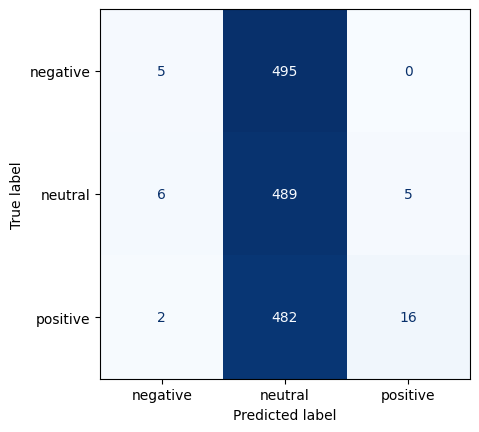

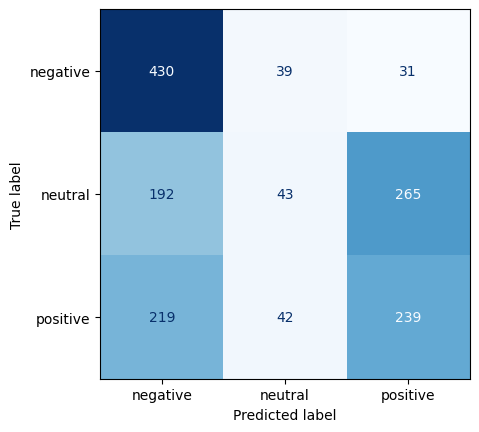

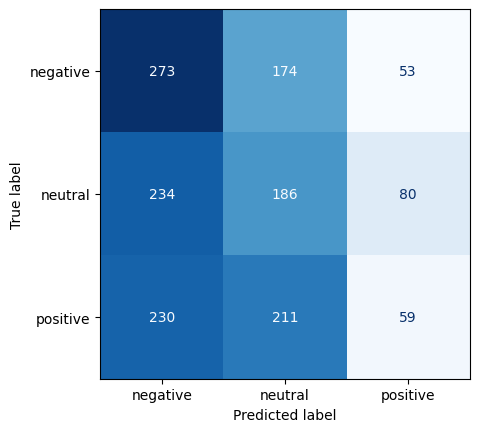

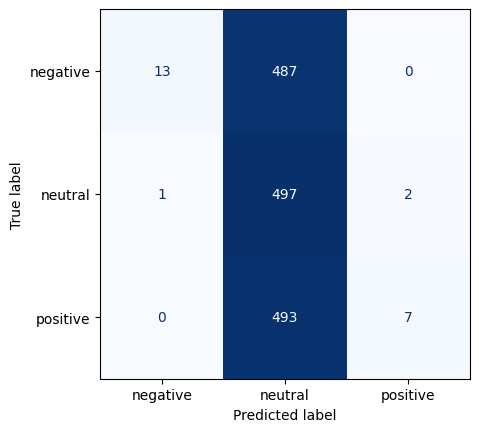

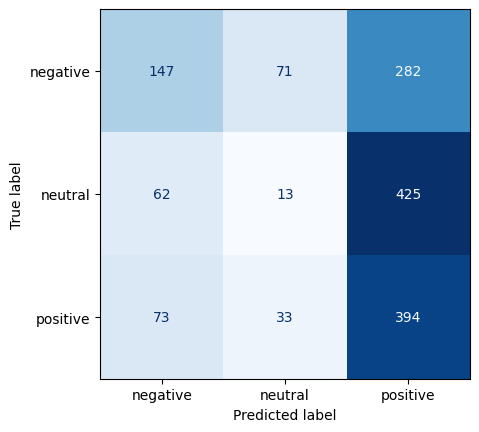

In [178]:
matricies = get_confusion_matricies(validation_data);